### Submission by Durgesh Vikram Yadav (2011MT10)

# Google Dataset

In [28]:
#Importing Libraries
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt 
import warnings
warnings.simplefilter('ignore')

In [29]:
#Downloading data
googl = pdr.DataReader('GOOGL', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30))

In [30]:
#Exporting and saving as csv files
googl.to_csv('Apple_stock.csv', sep=',')

In [31]:
#Printing the first few lines of data
googl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-08-01,583.429993,570.299988,578.549988,573.599976,2213300,573.599976
2014-08-04,583.820007,572.260010,576.510010,582.270020,1519400,582.270020
2014-08-05,580.200012,570.309998,579.380005,573.140015,1643800,573.140015
2014-08-06,578.640015,567.450012,569.500000,574.489990,1322800,574.489990
2014-08-07,578.309998,569.429993,576.049988,571.809998,1163000,571.809998


Text(0.5, 1.0, 'Close Price history vs Time')

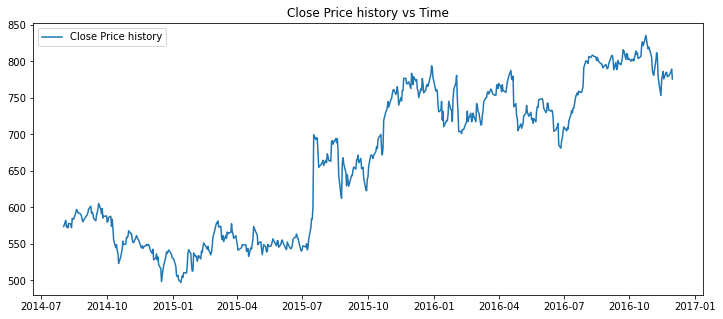

In [32]:
#Visulaizing the data
plt.figure(figsize=(12,5))
plt.plot(googl['Close'], label='Close Price history')
plt.legend()
plt.title('Close Price history vs Time')

Perform basic EDA to analyse the Data Frame

###ADF and KPSS Tests

In [33]:
#Importing libraries
from statsmodels.tsa.stattools import adfuller,kpss

a) ADF Test

In [34]:
def adf_test(atr):
    #Perform Dickey-Fuller test:
    timeseries = googl[atr].dropna()
    print ('Results of Dickey-Fuller Test for ',atr,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('Close')

Results of Dickey-Fuller Test for  Close 

Test Statistic                  -1.092577
p-value                          0.718023
#Lags Used                       3.000000
Number of Observations Used    585.000000
Critical Value (1%)             -3.441578
Critical Value (5%)             -2.866493
Critical Value (10%)            -2.569408
dtype: float64


Since p value is greater than 0.05, therefore, we fail to reject the null hypothesis and the data is non-stationary.

b) KPSS Test

In [35]:
def kpss_test(atr):
    timeseries = googl[atr].dropna()
    print ('Results of KPSS Test for ',atr)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('Close')

Results of KPSS Test for  Close
Test Statistic            2.648792
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


From KPSS Test, the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary).

Both tests conclude that the series is not stationary -> series is not stationary

###ACF and PACF Tests

a) ACF Test

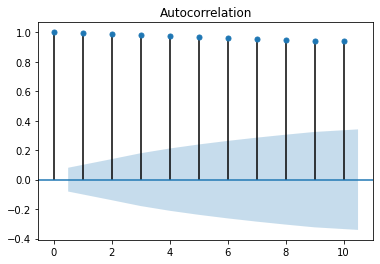

In [36]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(googl['Close'].dropna(), lags=10)
plt.show()

b) PACF Test

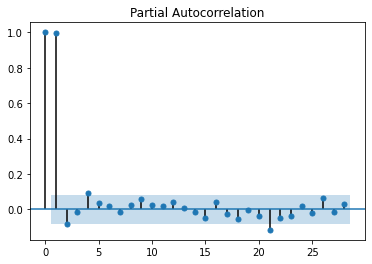

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(googl['Close'])
plt.show()

From ACF and PACF plots, since more than 5% of the plot is outside the shaded region, the data is non stationary.

### Differencing to make data as stationary

In [38]:
#Differencing the data
googl['diff'] = googl['Close'].diff(periods=1)

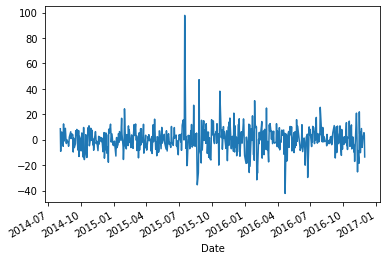

In [39]:
#Visulaizing the differenced data
googl["diff"].plot()

In [40]:
# ADF Test of differenced data
adf_test('diff')

Results of Dickey-Fuller Test for  diff 

Test Statistic                -1.479016e+01
p-value                        2.177423e-27
#Lags Used                     2.000000e+00
Number of Observations Used    5.850000e+02
Critical Value (1%)           -3.441578e+00
Critical Value (5%)           -2.866493e+00
Critical Value (10%)          -2.569408e+00
dtype: float64


Since p value is less than 0.05, therefore, we reject the null hypothesis and the differenced data is stationary.

In [41]:
# KPSS Test of differenced data
kpss_test('diff')

Results of KPSS Test for  diff
Test Statistic            0.073196
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


From KPSS Test, the test statistic is less than the critical value, we fail to reject the null hypothesis (differenced series is stationary).

Both tests conclude that the differenced series is stationary -> series is stationary.

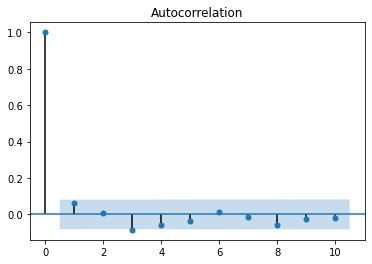

In [42]:
# ACF Test of differenced data
plot_acf(googl['diff'].dropna(), lags=10)
plt.show()

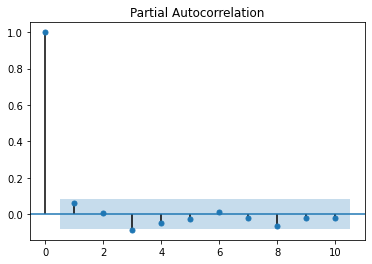

In [43]:
# PACF Test of differenced data
plot_pacf(googl['diff'].dropna(), lags=10)
plt.show()

From ACF and PACF plots, since less than 5% of the plot is outside the shaded region, the differenced data is stationary.



---



---



---



## Univariate Outliers:

In [44]:
#Deleting differenced data column 'diff'
del googl["diff"]

In [45]:
googl.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

There are no null values in the data frame

We will plot a simple box plot which is the best visualization for detecting outliers

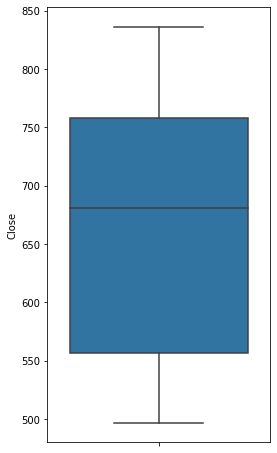

In [46]:
#Box plot for Close column of dataset
import seaborn as sns 
plt.figure(figsize = (4,8))
sns.boxplot(y = googl.Close)

#### Let's define a function to find out the IQR, lower and the upper whisker.

In [47]:
def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

In [48]:
#Input the dataset and the required column
out_iqr(googl,'Close')

The IQR is 200.84002685546875
The lower bound value is 255.54995727539062
The upper bound value is 1058.9100646972656
Total number of outliers are 0


We can see here that there are 0 outliers in Close column of datsaset.

### Visual representation:

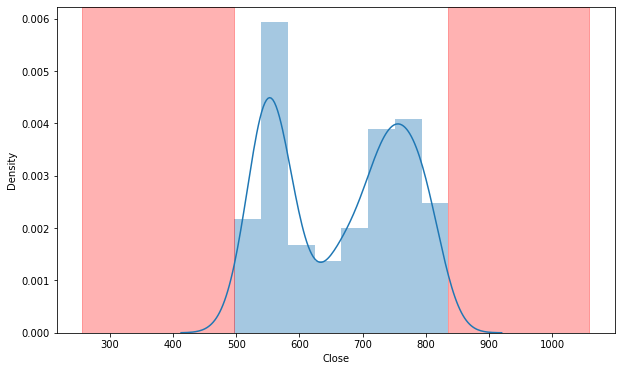

In [49]:
plt.figure(figsize = (10,6))
sns.distplot(googl.Close, kde=True)
plt.axvspan(xmin = lower,xmax= googl.Close.min(),alpha=0.3, color='red')
plt.axvspan(xmin = upper,xmax= googl.Close.max(),alpha=0.3, color='red')

Here the red zone represents the outlier zone.



---



## Mulitivariate Outliers:

### 1) DBSCAN (Density-Based Spatial Clustering of Applications with Noise):

We are considering the Open and Close columns of the dataset.

In [50]:
from sklearn.cluster import DBSCAN
X = googl[['Open','Close']].values

db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_

In [51]:
pd.Series(labels).value_counts()

-1    478
 0     60
 1     22
 3     19
 2     10
dtype: int64

Here the -1's represent the outliers and 0 represent not outlier. 

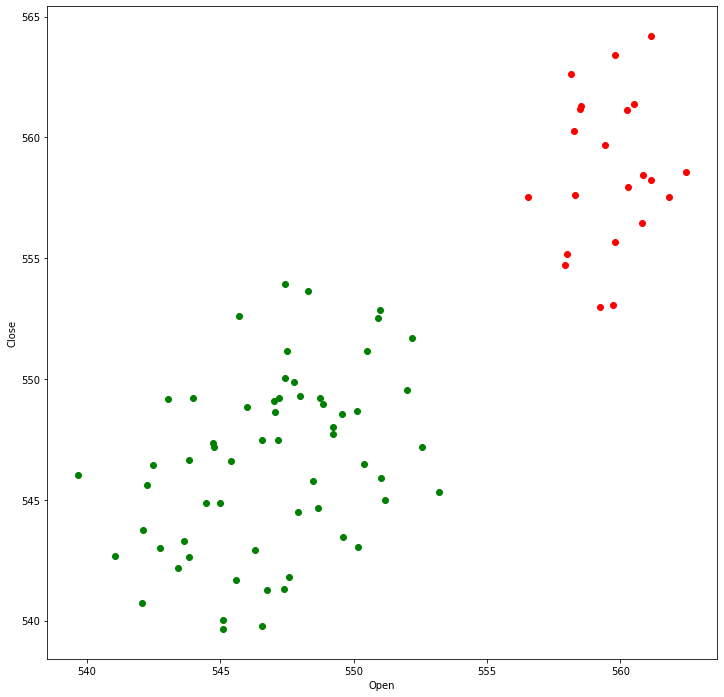

In [52]:
plt.figure(figsize=(12,12))

unique_labels = set(labels)
colors = ['green','red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Open');
plt.ylabel('Close');




---



### 2) Local Outlier Factor Method(LOF):

In [53]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')
X = googl[['Open','Close']].values
y_pred = clf.fit_predict(X)

 Now let's plot and visualize the outliers. I've set blue for the normal records and red for outliers

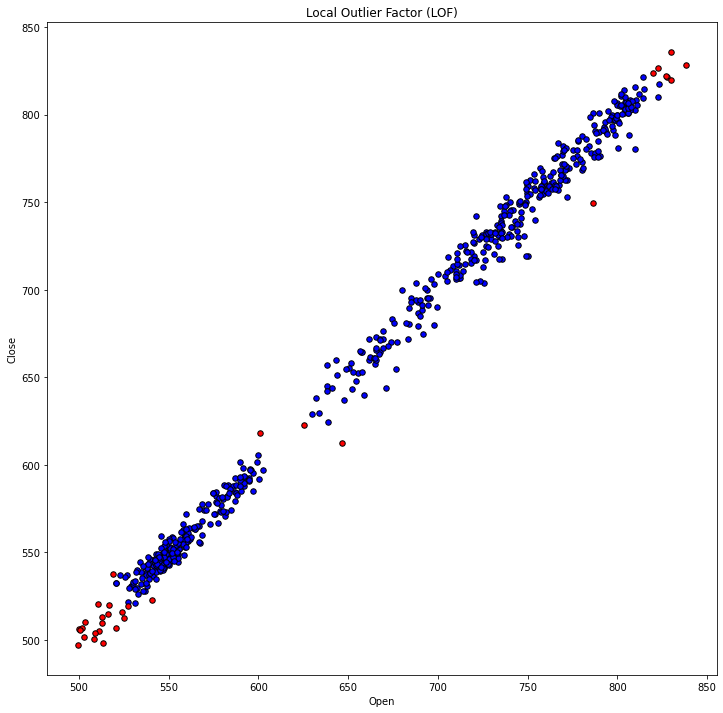

In [54]:
plt.figure(figsize=(12,12))
# plot the level sets of the decision function

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
plt.axis('tight');
plt.xlabel('Open');
plt.ylabel('Close');
plt.show()

Here, blue coloured ones are normal data and red ones are outliers.